# EVALUACIÓN DE APTITUD TERRITORIAL PARA IDENTIFICACIÓN DE ZONAS DE EXPANSIÓN URBANA PARA MUNICIPIOS INTERMEDIOS 

**OBJETIVO PROYECTO**


Identificar áreas potenciales de expansión urbana considerando criterios demográficos, ambientales, físicos y de accesibilidad, a través de herramientas de análisis espacial.


# 1. Notebook Preparación de datos

**Proyecto Final Programación SIG**

**Maestria en Geomática**

Estudiantes: 
* Sara Alarcon Prieto
* Gizela Guzmán Lugo
  

Fecha: 09/07/2025

## 1.1 INTRODUCCIÓN
 
Este notebook tiene como propósito preparar los datos necesarios para el análisis espacial posterior, asegurando su calidad y consistencia. Para ello, se realizan actividades de proyección de sistemas de referencia, recorte al área de interés, filtrado mediante la selección de atributos, generación de áreas de influencia y mapas de pendientes. Estas acciones permiten depurar y estructurar los criterios necesarios para el análisis espacial e identificar zonas potenciales de expansión.

## 1.2 IMPORTACIÓN LIBRERIAS

Se importan las librerías necesarias para llevar a cabo el análisis espacial. Estas herramientas permiten cargar, procesar, visualizar y transformar datos geográficos.

In [70]:
# Importación de bibliotecas
import geopandas as gpd  # Manejo de datos espaciales vectoriales
import pandas as pd      # Manejo de datos tabulares
import shapely as shp    # Creación y manipulación de geometrías (puntos, líneas, polígonos)
from shapely.geometry import shape  # Conversión de diccionarios GeoJSON a objetos geométricos de Shapely

import rasterio as rs    # Lectura, escritura y manejo de datos raster
import rasterio.plot     # Funciones para visualizar datos raster 
from rasterio.crs import CRS   # Manejo de CRS en raster
from rasterio.features import shapes  # Conversión de raster a vectores mediante poligonización
import numpy as np       # Operaciones numéricas eficientes y manejo de arreglos

import matplotlib.pyplot as plt  # Visualización de datos (gráficas, mapas)
import matplotlib.patches as mpatches  # Creación de parches para leyendas personalizadas
from matplotlib.patches import Patch   # Parches para leyendas 
from matplotlib.lines import Line2D    # Creación de líneas personalizadas para leyendas
from matplotlib.colors import ListedColormap # Creación paletas de colores personalizadas
import contextily as ctx #Permite agregar mapas base
import os # Permite interactuar con el sistema operativo

import sys # Módulo que permite manipular el sistema
sys.path.append('../src')  # subir un nivel de carpeta y entrar a src(carpeta con funciones)

import data_preprocessing # Módulo que contiene funciones de preprocesamiento de datos
from data_preprocessing import clip_vector  # Importación funcion de recorte 
from data_preprocessing import buffer_areas_influencia # Función áreas de influencia - Buffer

import visualization_tools  # Módulo que contiene funciones para visualización 
from visualization_tools import plot_uso_suelo  # Función de visualización de mapa categórico de uso suelo con leyenda personalizada
from visualization_tools import plot_coberturas  # Función de visualización de mapa categórico de coberturas con leyenda personalizada
from visualization_tools import plot_amenazas # Función de visualización de mapa categórico de Amenazas con leyenda personalizada
from visualization_tools import visualizar_dem # Función de visualización general DTM y generación histograma

## 1.3. PREPARACIÓN DE DATOS 

En la etapa inicial del procesamiento geoespacial, se realiza la importación y estandarización de los datos necesarios para el análisis, estos datos incluyen tanto información vectorial como raster:

**Datos Usados**

1. **Limite Municipal** – Shapefile del limite de Interes - IGAC 
2. **Limites centros poblados** Shapefile de los limites de los centros poblados -DANE
3. **Clasificación uso de suelo** – Shapefile Clasificación uso de suelo - POT  
4. **Coberturas de la tierra** – Shapefile Mapa de Cobertura de la Tierra. Adaptación Corine Land Cover. Escala 1:100.000. Periodo 2018- IDEAM
5. **Zonificación amenaza por remoción en masa** - Shapefile Zonificación de Amenazas por movimientos en masa - SGC
6. **Vías** - shapefile de vias y limite vias, omitiendo caminos
7. **Drenajes sencillos** -shapefile de drenajes intermitentes y permanestes - MINTIC
8. **Drenajes Dobles** - shapefile de drenajes dobles - MINTIC
9. **Lagunas**- shapefile de cuerpos de agua - MINTIC
10. **Modelo Digital de terreno** - Raster del Modelo digital de terreno del Municipio, resolución 1 m, Año 2023 - IGAC

### 1.3.1 Cargue de los datos

Lo primero que se realiza es el cargue de los datos para el análisis espacial y evaluación multicriterio. Para garantizar la correcta superposición e interoperabilidad entre los datos, todos son reproyectados al sistema de referencia EPSG:9377 (Magna_sirgas_Origen_Nacional), que es adecuado para análisis espaciales precisos a nivel de Colombia.

In [71]:
#Definición de la ruta que contiene los datos
Ruta_Carpeta=r"/notebooks/PROYECTO_FINAL/Datos"

Municipio_interes = Ruta_Carpeta+'/TOCANCIPA.shp'  #Shapefile limite Municipal  
Centros_poblados = Ruta_Carpeta+'/Centros_Poblados_Cundinamarca.shp' #Shapefile limite centros poblados
Clasificacion_suelo = Ruta_Carpeta+'/Clasificacion_suelo_Cundinamarca.shp' # Shapefile con clasificación uso del suelo POT
Coberturas_tierra = Ruta_Carpeta+'/Coberturas_Cundinamarca.shp' #Shapefile Mapa de Cobertura de la Tierra
Zon_Amenazas = Ruta_Carpeta+'/Remocion_Cundinamarca.shp' #Shapefile Zonificación de Amenazas por movimientos en masa
drenaje_sencillo = Ruta_Carpeta+'/drenaje_sencillo.shp' #Shapefile de drenajes sencillos
drenaje_doble = Ruta_Carpeta+'/drenaje_doble.shp' #Shapefile de drenajes dobles
lagunas = Ruta_Carpeta+'/laguna.shp' #Shapefile de lagunas
vias_vias = Ruta_Carpeta+'/via.shp' #Shapefile de eje vial
vias_lvias = Ruta_Carpeta+'/limite_via.shp' #Shapefile de limites de vias -urbano
DTM = Ruta_Carpeta+'/MDT_Tocancipa.tif' #Raster del Modelo digital de terreno del Municipio

#Rutas de salida
Mapa_pend = Ruta_Carpeta+'/MDT_Tocancipa_slope_pct.tif' #Ruta donde se guardará mapa de pendientes
output_folder_maps = r"/notebooks/PROYECTO_FINAL/results/maps"

**Cargue datos vectoriales**

Se realiza el cargue de los datos vectoriales necesarios para el análisis espacial utilizando geopandas. De manera inmediata, cada capa se reproyecta al sistema de referencia de coordenadas EPSG:9377, asegurando que todas las capas compartan la misma proyección y sistema de coordenadas.

In [72]:
# Cargue de datos vectoriales
# Lectura y reproyección al sistema de referencia EPSG:9377
municipio = gpd.read_file(Municipio_interes).to_crs(epsg=9377)
Centros_pob = gpd.read_file(Centros_poblados).to_crs(epsg=9377)
uso_suelo = gpd.read_file(Clasificacion_suelo).to_crs(epsg=9377)
coberturas = gpd.read_file(Coberturas_tierra).to_crs(epsg=9377)
Amenaza = gpd.read_file(Zon_Amenazas).to_crs(epsg=9377)
drenaje_sencillo = gpd.read_file(drenaje_sencillo).to_crs(epsg=9377)
drenaje_doble = gpd.read_file(drenaje_doble).to_crs(epsg=9377)
lagunas = gpd.read_file(lagunas).to_crs(epsg=9377)
vias_vias = gpd.read_file(vias_vias).to_crs(epsg=9377)
vias_lvias = gpd.read_file(vias_lvias).to_crs(epsg=9377)

**Cargue datos raster**

Se realiza el cargue del Modelo Digital del Terreno (MDT) en formato raster utilizando la biblioteca rasterio. Se abre el archivo raster en modo lectura para extraer la primera banda, que contiene los valores de elevación de cada píxel, y se almacenan variables clave para su análisis posterior.

In [73]:
# Cargue de datos raster
with rs.open(DTM) as src:
    dtm = src.read(1)  
    transform = src.transform
    crs = src.crs
    pixel_size_x = transform[0]
    pixel_size_y = -transform[4]  

# Impresión metadatos DTM
print("Metadatos DTM", src.meta)

Metadatos DTM {'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 1700, 'height': 1700, 'count': 1, 'crs': CRS.from_wkt('PROJCS["MAGNA-SIRGAS 2018 / Origen-Nacional",GEOGCS["MAGNA-SIRGAS 2018",DATUM["Marco_Geocentrico_Nacional_de_Referencia_2018",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","1329"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","20046"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",4],PARAMETER["central_meridian",-73],PARAMETER["scale_factor",0.9992],PARAMETER["false_easting",5000000],PARAMETER["false_northing",2000000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["X",EAST],AXIS["Y",NORTH],AUTHORITY["EPSG","9377"]]'), 'transform': Affine(10.0, 0.0, 4888000.0,
       0.0, -10.0, 2116000.0)}


### 1.3.2 Recorte de los datos

Se recortan los datos con el limite del municipio de interes, lo cual permite trabajar solo con los datos que se encuentran dentro de la zona geográfica de interés; y asi optimizar el rendimiento computacional
al reducir la cantidad de datos, se acelera el procesamiento, se disminuye el uso de memoria y almacenamiento, y se mejora la eficiencia de las tareas de análisis, visualización y modelamiento.

Para ello se utiliza una función creada para el recorte, la cual automatiza el preprocesamiento espacial, la cual incluye validaciones adicionales como reproyecciones y eliminación de geometrías vacías.

In [74]:
# Corte de los datos con el municipio de interes
centros_pob_clip= clip_vector(Centros_pob, municipio)
uso_suelo_clip= clip_vector(uso_suelo, municipio)
coberturas_clip= clip_vector(coberturas, municipio)
Amenaza_clip= clip_vector(Amenaza, municipio)

### 1.3.3 Visualizacion general de datos

La visualización previa de los datos geográficos permite la validación del cargue y proyección de las capas, ademas de explorar, verificar y facilitar la comprensión del territorio para la toma de decisiones fundamentadas.

**Visualización raster**

Se utiliza una función que permite generar:

* Histograma de elevaciones, para analizar la distribución de las altitudes presentes en el área de estudio, identificar rangos de valores frecuentes y detectar posibles valores atípicos.

* Mapa del DEM, permitiendo la interpretación espacial de las variaciones de elevación en el territorio.

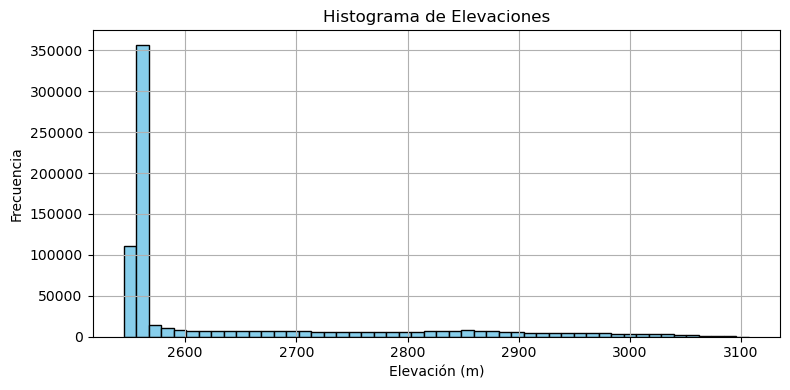

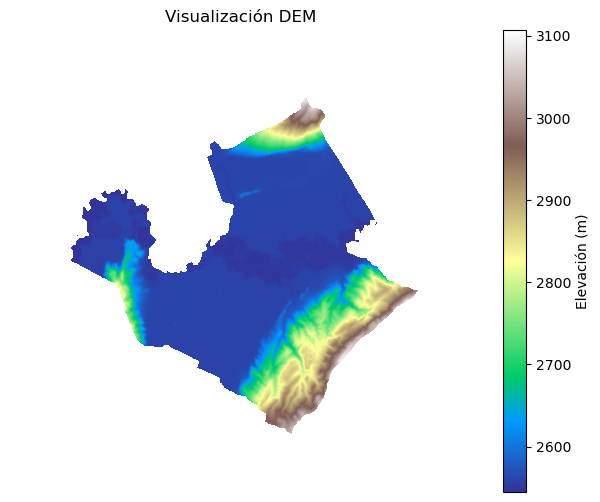

In [75]:
# Visualización DEM
visualizar_dem(dtm_masked)

**Visualización capas vector**

A continuación se visualizan los datos vectoriales de la zona de estudio, permitiendo interpretar de manera clara la infraestructura, hidrografía y características temáticas del territorio. 

En primer lugar, se presenta la distribución de centros poblados y la red vial sobre el polígono del municipio de estudio, como referencia del área de análisis. 


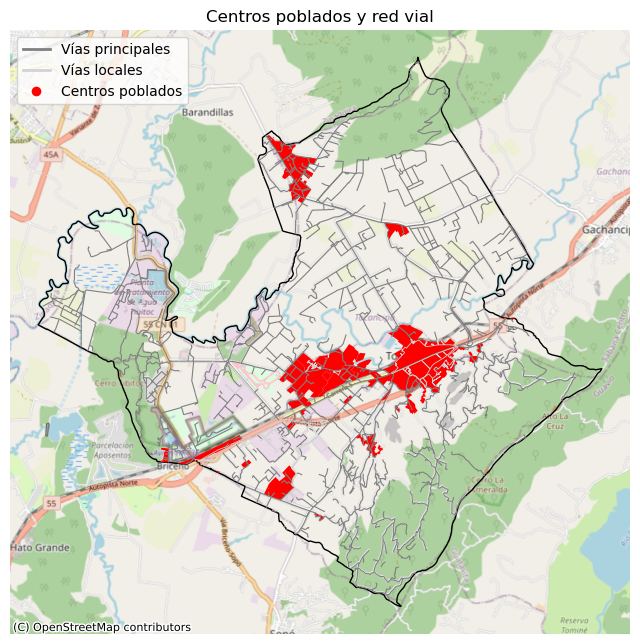

In [76]:
# centros poblados y red vial
# Ajuste visualización
fig, ax = plt.subplots(figsize=(8, 8))
municipio.plot(ax=ax, color='none', edgecolor='black')
vias_vias.plot(ax=ax, color='gray', linewidth=0.8)
vias_lvias.plot(ax=ax, color='lightgray', linewidth=0.6)
centros_pob_clip.plot(ax=ax, color='red', markersize=10)

ax.set_title("Centros poblados y red vial")
ax.axis('off')

# Leyenda personalizada
leyenda_1 = [
    Line2D([0], [0], color='gray', linewidth=2, label='Vías principales'),
    Line2D([0], [0], color='lightgray', linewidth=2, label='Vías locales'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Centros poblados'),
]
ax.legend(handles=leyenda_1, loc='upper left')

# Agregar mapa base
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=municipio.crs.to_string(),  # Asegura usar el CRS correcto
  )

plt.show()

# Guardar el mapa generado 
fig.savefig(
    os.path.join(output_folder_maps, "Centros_poblados_red_vial.png"),
    dpi=300,
    bbox_inches='tight'
)

Posteriormente, se visualizan las capas hídricas, donde se incluyen drenajes sencillos, drenajes dobles y lagunas presentes en el área de estudio, facilitando la identificación de cuerpos de agua relevantes para el análisis territorial. 

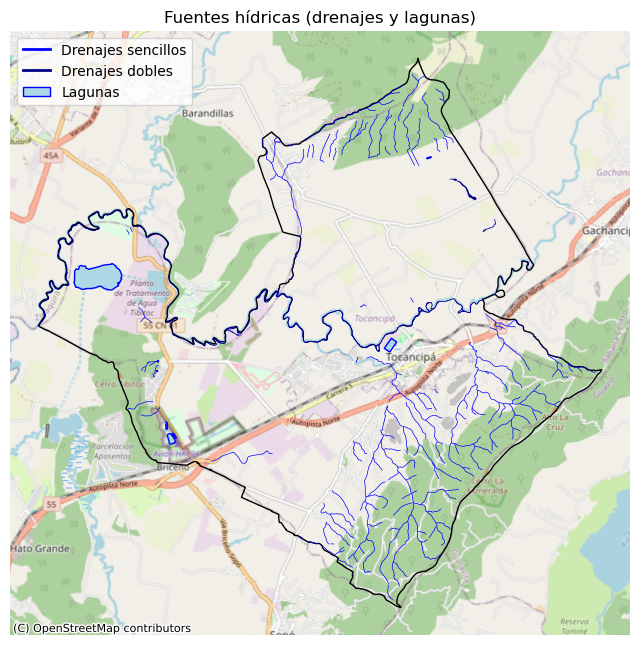

In [77]:
# capas hidricas
# Ajuste visualización
fig, ax = plt.subplots(figsize=(8, 8))
municipio.plot(ax=ax, color='none', edgecolor='black')
drenaje_sencillo.plot(ax=ax, color='blue', linewidth=0.5)
drenaje_doble.plot(ax=ax, color='darkblue', linewidth=0.7)
lagunas.plot(ax=ax, color='lightblue', edgecolor='blue')

ax.set_title("Fuentes hídricas (drenajes y lagunas)")
ax.axis('off')

# Leyenda personalizada
leyenda_2 = [
    Line2D([0], [0], color='blue', linewidth=2, label='Drenajes sencillos'),
    Line2D([0], [0], color='darkblue', linewidth=2, label='Drenajes dobles'),
    Patch(facecolor='lightblue', edgecolor='blue', label='Lagunas')
]
ax.legend(handles=leyenda_2, loc='upper left')

# Agregar mapa base
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=municipio.crs.to_string(),  # Asegura usar el CRS correcto
  )

plt.show()

# Guardar el mapa generado 
fig.savefig(
    os.path.join(output_folder_maps, "Fuentes_hidricas.png"),
    dpi=300,
    bbox_inches='tight'
)


Finalmente, mediante funciones específicas desarrolladas para este proyecto, se generan visualizaciones de capas temáticas categóricas que representan el uso actual del suelo, coberturas de la tierra y zonificación de amenazas sobre el municipio de estudio. Estas visualizaciones emplean escalas de color específicas para cada categoría, leyendas personalizadas y referencias claras, permitiendo analizar de forma integrada variables relevantes para la caracterización del territorio. 

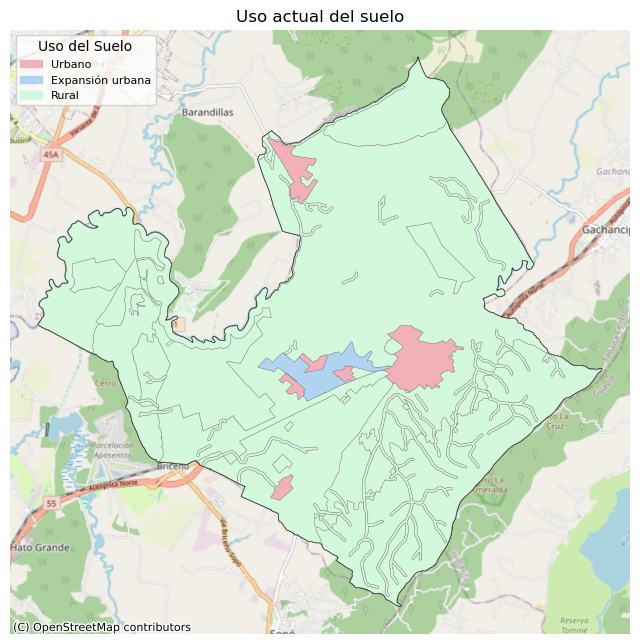

In [78]:
#Visualización uso actual del suelo

# Función de visualización de mapa categórico de uso suelo con leyenda personalizada
fig, ax = plot_uso_suelo(uso_suelo_clip, municipio)

# Guardar el mapa generado
fig.savefig(
    os.path.join(output_folder_maps, "Uso_actual_suelo.png"),
    dpi=300,
    bbox_inches='tight'
)

plt.show()  # Para mostrar el mapa en el notebook

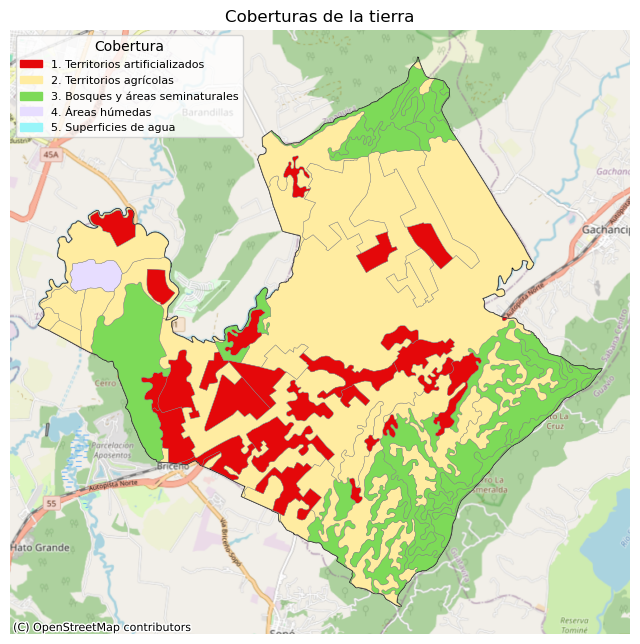

In [79]:
#Visualización coberturas de la tierra

# Función de visualización de mapa categórico de coberturas con leyenda personalizada
fig, ax = plot_coberturas(coberturas_clip, municipio)

# Guardar el mapa generado
fig.savefig(
    os.path.join(output_folder_maps, "Coberturas_de_la_tierra.png"),
    dpi=300,
    bbox_inches='tight'
)

plt.show()  # Para mostrar el mapa en el notebook


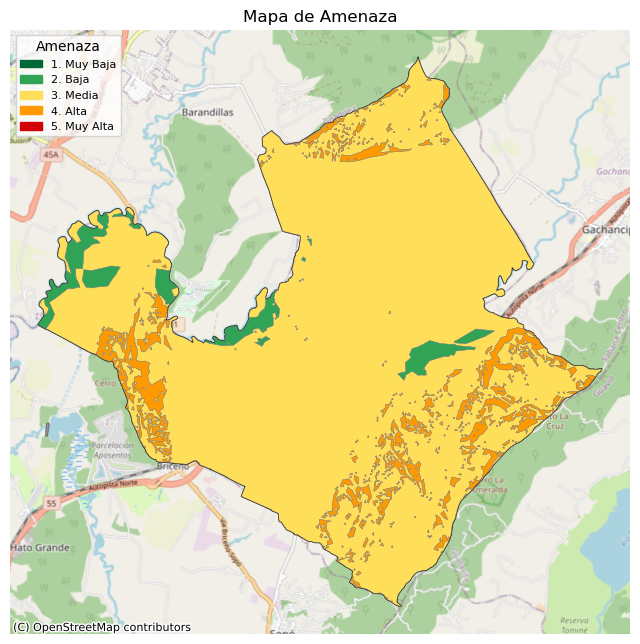

In [80]:
#Visualización zonificación  de amenazas

# Función de visualización de mapa categórico de Amenazas con leyenda personalizada
fig, ax = plot_amenazas(Amenaza_clip, municipio)

# Guardar el mapa generado
fig.savefig(
    os.path.join(output_folder_maps, "Zonificación_Amenazas.png"),
    dpi=300,
    bbox_inches='tight'
)

plt.show()  # Para mostrar el mapa en el notebook



## 1.4 PRE-PROCESAMIENTO DE DATOS

### 1.4.1 Exploración de datos

En esta sección se realiza la exploración inicial de los datos espaciales y tabulares utilizados en el análisis, con el objetivo de verificar la estructura, identificando las columnas disponibles y comprendiendo la información que contienen. Este paso permite determinar qué datos son necesarios para el filtrado y selección de capas en las etapas posteriores del análisis.

In [81]:
# Visualización de las primeras filas de las capas para verificación
print("Zonificación de amenazas\n", Amenaza_clip.head())
print("\nCoberturas de la tierra\n", coberturas_clip.head())
print("\nUso actual del suelo\n", uso_suelo_clip.head())

Zonificación de amenazas
              Id  gridcode    Catame   Amenaza  \
304321  3691129         2  3. Media  3. Media   
293029  3214292         3   4. Alta   4. Alta   
290776  3194255         3   4. Alta   4. Alta   
288413  3176082         3   4. Alta   4. Alta   
290866  3194971         3   4. Alta   4. Alta   

                                                 geometry  
304321  MULTIPOLYGON (((4901193.061 2107436.865, 49009...  
293029  MULTIPOLYGON (((4896716.809 2102387.928, 48967...  
290776  POLYGON ((4893174.44 2104473.646, 4893247.206 ...  
288413  POLYGON ((4893245.571 2106947.937, 4893218.478...  
290866  POLYGON ((4893142.099 2104367.732, 4893172.943...  

Coberturas de la tierra
        codigo                                            leyenda  \
7953      122  1.2.2. Red vial, ferroviaria y terrenos asociados   
10542     231                              2.3.1. Pastos limpios   
8241     3221                            3.2.2.1. Arbustal denso   
8252      242        

### 1.4.2 Filtrado de capas 

Antes de llevar a cabo el análisis multicriterio, se realiza un proceso de filtrado temático de las capas geográficas con el fin de extraer únicamente los subconjuntos de información que son pertinentes para el objetivo del estudio. Este paso permite reducir la complejidad de los datos y enfocar el análisis en las variables para delimitar zonas de expansión urbana.

Los filtros aplicados se enfocan en las siguientes categorías:

* Zonas con amenaza alta y muy alta de remoción en masa, extraídas de la capa de amenazas, para identificar áreas con restricciones por riesgo geotécnico.

* Coberturas de tipo "bosques y áreas seminaturales", seleccionadas desde la capa de coberturas de la tierra, para considerar las restricciones ambientales asociadas a ecosistemas estratégicos.

* Pastos, también filtradas desde la capa de coberturas de la tierra suelo, áreas con potencial de transformación, para futuros desarrollos urbanos sin comprometer áreas de alto valor ambiental o productivo.

* Suelos de protección, extraídos de la capa de uso actual del suelo, los cuales deben ser preservados por su valor ecológico, ambiental o de riesgo.



In [82]:
# Amenaza de movimientos en masa alta y muy alta
Amenaza_alta = Amenaza_clip[Amenaza_clip['Amenaza'].isin(['4. Alta', '5. Muy Alta'])]

# Coberturas bosques
Bosques = coberturas_clip[coberturas_clip['nivel_1'] == '3. Bosques y áreas seminaturales']

# Paastos
Pastos = coberturas_clip[coberturas_clip['nivel_2'] == '2.3. Pastos']

#Suelo de protección
Suelo_Proteccion = uso_suelo_clip[uso_suelo_clip['Tipo_Suelo'] == 'Suelo de protección']



### 1.4.3 Generación mapa de pendientes
El análisis de la pendiente del terreno es un criterio fundamental en la planificación territorial y en la identificación de zonas aptas para la expansión urbana. Generar un mapa de pendientes permite evaluar la topografía del área de estudio, identificando las zonas con mayor facilidad para urbanizar y aquellas donde existen restricciones físicas para el desarrollo.

A partir del Modelo Digital de Terreno (MDT), se genera el mapa de pendientes mediante la herramienta gdaldem de la biblioteca GDAL, que permite calcular métricas topográficas de forma eficiente y reproducible en entornos de análisis espacial.

In [83]:
# Generación mapa de pendientes con gdal

#Generar ruta de Salida
# os.path.splitext(path_dem) divide la ruta del archivo en dos partes:
#   (1) el nombre base (sin la extensión)
#   (2) la extensión, por ejemplo, '.tif'
# Al seleccionar [0], se recupera únicamente el nombre base.

# Luego, se agrega un sufijo ('_slope.tif') para indicar el 
# atributo del terreno que se está calculando

out_slope  = os.path.splitext(DTM)[0] + '_slope.tif'
out_slope_perc  = os.path.splitext(DTM)[0] + '_slope_pct.tif'


# Ejecutar gdaldem dentro de Python
# La opción '-of GTiff' especifica el formato de archivo de salida
#Al ejecutar gdaldem exporta los archivos directamente

# utiliza el código EPSG (en lugar de WKT) para definir el CRS
os.environ["GTIFF_SRS_SOURCE"] = "EPSG"

# (a) Slope: 0–90 grados
os.system(f'gdaldem slope "{DTM}" "{out_slope}" -of GTiff')

# (b) Slope en porcentaje
os.system(f'gdaldem slope "{DTM}" "{out_slope_perc}" -of GTiff -p')


0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


0

Posteriormente, Se realiza la visualización del mapa de pendientes calculado a partir del MDT. Primero, se abre el archivo raster de pendiente en modo edición para asignar manualmente el sistema de referencia de coordenadas EPSG:9377 en caso de que no haya sido definido durante su generación. Luego, se leen los valores de pendiente almacenados en la primera banda del raster para su visualización.

Para mejorar la interpretación, se genera una máscara que ignora valores nulos o de error (-9999.0), evitando que se muestren en el mapa final.

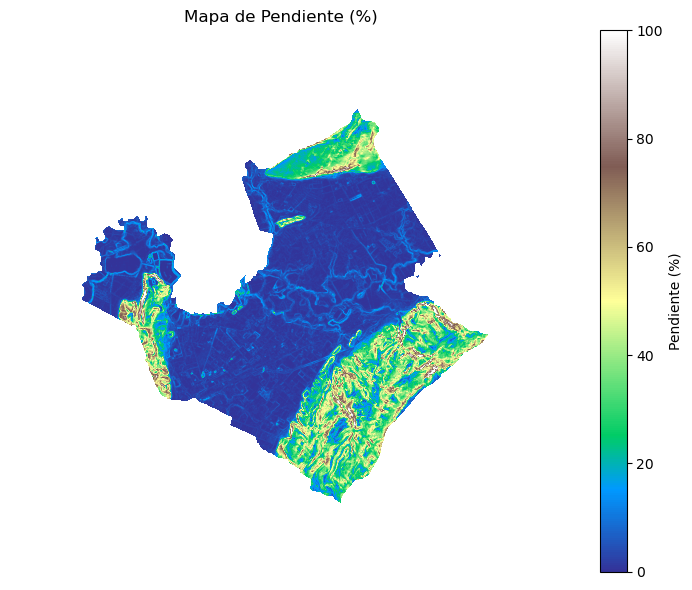

In [84]:
# Abrir el archivo raster de pendiente en modo edición 
# Para asignar manualmente el CRS correcto (EPSG:9377) si no se definió al exportar
with rasterio.open(Mapa_pend, "r+") as src_pend:
    src_pend.crs = CRS.from_epsg(9377) # Asigna CRS en modo edición
    
# Lee los valores de la pendiente para visualización
with rasterio.open(Mapa_pend) as src_pend:
    slope_array = src_pend.read(1)  # Lee la primera banda del raster

# Crear una máscara para ignorar valores 0 en la visualización
slope_masked = np.ma.masked_where(slope_array ==-9999.0, slope_array)

# Visualización del mapa de pendientes ignorando valores 0
fig, ax = plt.subplots(figsize=(10, 6))

# Muestra el raster con cmap 'terrain' y la máscara aplicada
cax = ax.imshow(slope_masked, cmap='terrain', vmin=0, vmax=100)

# Añade barra de color
cbar = fig.colorbar(cax, ax=ax, label='Pendiente (%)')

# Configura el título y oculta los ejes
ax.set_title("Mapa de Pendiente (%)")
ax.axis('off')

# Ajusta el diseño para evitar recortes
plt.tight_layout()
plt.show()

# Guardar el mapa generado 
fig.savefig(
    os.path.join(output_folder_maps, "Mapa_pendientes.png"),
    dpi=300,
    bbox_inches='tight'
)

### 1.4.4 Clasificación mapa de pendientes

Se realiza la clasificación del mapa de pendientes derivado del MDT para facilitar su análisis. Primero, se vuelve a abrir el raster de pendiente en modo lectura utilizando rasterio, permitiendo cargar la banda que contiene los valores de pendiente en porcentaje. 

Luego, se crea una matriz vacía de clases con las mismas dimensiones que el raster de pendiente, donde cada celda se asigna a una categoría según rangos definidos, transformando el raster continuo de pendientes en un raster categórico:

* 0 para áreas planas o sin datos,

* 1 para pendientes bajas (0–15%),

* 2 para pendientes altas (>15%).

Finalmente, se actualizan los metadatos del raster de salida. Este archivo resultante permite identificar visualmente y cuantificar las áreas según el rango de pendiente, contribuyendo a la toma de decisiones en estudios de expansión urbana.

In [85]:
# Clasificación mapa de pendientes

# Vuelve a abrir el raster de pendiente en modo lectura para procesarlo    
with rasterio.open(Mapa_pend) as src_pend:
    slope_percent = src_pend.read(1).astype(float)   # Lee la primera banda
    out_meta = src_pend.meta.copy()   # Copia metadatos (CRS, transform, etc.)
  
# Clasificación mapa de pendientes

# Crea una matriz vacía de clases con las mismas dimensiones que el raster
slope_class = np.zeros_like(slope_percent, dtype=np.uint8)

# Clasifica según rangos definidos
# 0 - No data / plano
# 1 - Baja pendiente (0–15%)
# 2 - Alta pendiente (>15%)

slope_class[(slope_percent >= 0) & (slope_percent < 15)] = 1
slope_class[slope_percent >= 15] = 2

# Actualiza metadatos para el raster de salida
out_meta.update({
    "driver": "GTiff",
    "dtype": rasterio.uint8,
    "count": 1,
    "nodata": 0
})

# Guarda el raster clasificado
output_tif = 'slope_classified.tif'
with rasterio.open(output_tif, "w", **out_meta) as dest:
    dest.write(slope_class, 1)

print(f"Raster de pendiente clasificado exportado: {output_tif}")

Raster de pendiente clasificado exportado: slope_classified.tif


### 1.4.5 Vectorización del mapa de pendientes

Se vectoriza el raster de pendientes clasificado para convertir las áreas de pendientes bajas y altas en polígonos, ignorando los valores de 0. Se crea un GeoDataFrame con la clase de pendiente y su geometría, lo que facilita el análisis espacial y la superposición con otras capas vectoriales. 

In [86]:
# Vectorización del raster clasificado

mask = slope_class != 0  # ignora nodata/clase 0 al vectorizar
results = (
    {"properties": {"slope_class": int(v)}, "geometry": s}
    for s, v in shapes(slope_class, mask=mask, transform=transform)
)

# Crear GeoDataFrame

#Inicializa listas vacías para almacenar geometrías y valores
geoms = []
values = []

# Recorre los resultados generados y separa geometrías y valores en listas
for result in results:
    geoms.append(shape(result["geometry"]))
    values.append(result["properties"]["slope_class"])

# Crea el GDF 'clas_pend' con las geometrías y la columna 'slope_class'
clas_pend= gpd.GeoDataFrame({"slope_class": values}, geometry=geoms, crs=CRS.from_epsg(9377))

print("GeoDataFrame de clases de pendiente generado.")

# Verificación del GDF
print(clas_pend.head())

GeoDataFrame de clases de pendiente generado.
   slope_class                                           geometry
0            2  POLYGON ((4898890 2113600, 4898890 2113580, 48...
1            1  POLYGON ((4898900 2113590, 4898900 2113580, 48...
2            1  POLYGON ((4898890 2113580, 4898890 2113570, 48...
3            2  POLYGON ((4898900 2113580, 4898900 2113570, 48...
4            1  POLYGON ((4898860 2113530, 4898860 2113520, 48...


Finalmente, se genera un mapa temático que distingue pendientes bajas (verde) y altas (rojo), permitiendo visualizar de forma clara las zonas según su rango de pendiente.

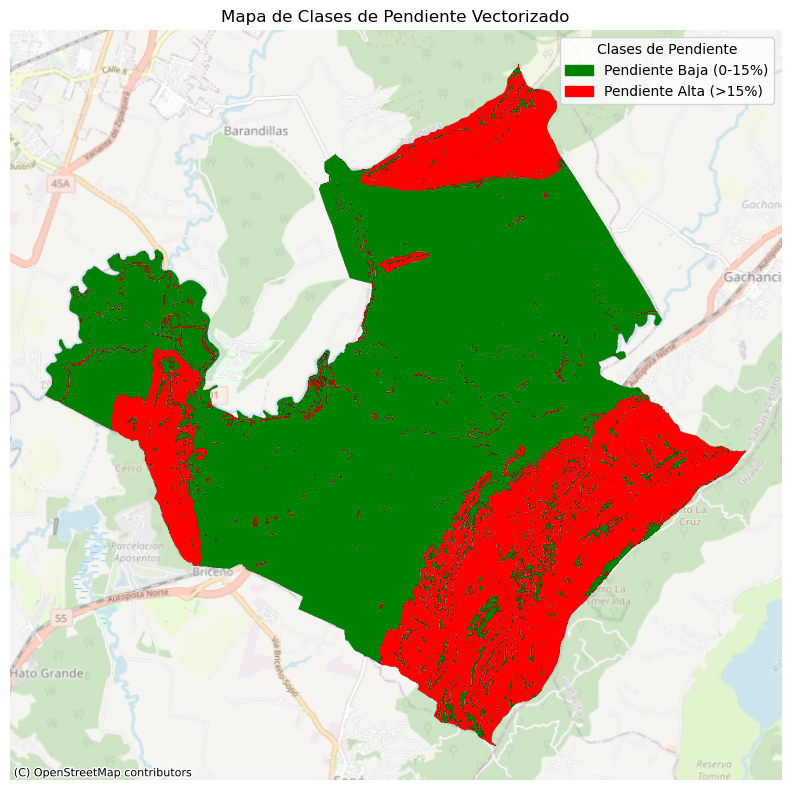

In [87]:
#Visualizacion mapa de pendientes por clase

# Define un diccionario que asigna colores a cada clase de pendiente:
colores = {
    1: 'green',  # Pendiente baja
    2: 'red',    # Pendiente alta
}

# Crea columna de color en el GeoDataFrame
clas_pend['color'] = clas_pend['slope_class'].map(colores)

# Crea figura
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

# Grafica GDF
clas_pend.plot(color=clas_pend['color'], edgecolor='black', linewidth=0.1, ax=ax)

# Agrega mapa base de OpenStreetMap
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=clas_pend.crs.to_string(),  # Asegura el CRS correcto del GDF
    alpha=0.6                        # Transparencia para ver colores de pendiente
)

# Crea leyenda manual
leyenda = [
    mpatches.Patch(color='green', label='Pendiente Baja (0-15%)'),
    mpatches.Patch(color='red', label='Pendiente Alta (>15%)')
]

# Añade la leyenda al mapa en la esquina superior derecha
plt.legend(handles=leyenda, loc='upper right', title='Clases de Pendiente')

# Títulos y estilo
ax.set_title("Mapa de Clases de Pendiente Vectorizado")
ax.axis('off')
plt.tight_layout()

# Mostrar
plt.show()

# Guardar el mapa generado 
fig.savefig(
    os.path.join(output_folder_maps, "Mapa_pendientes_vectorizado.png"),
    dpi=300,
    bbox_inches='tight'
)

### 1.4.6 Áreas influencia - Rondas hidricas

Para la identificación de zonas de expansión urbana, es fundamental delimitar las rondas hídricas, entendidas como las franjas de protección ambiental que rodean cuerpos y cursos de agua, tales como drenajes, canales y lagunas. La legislación ambiental colombiana prohíbe el desarrollo urbano dentro de estas zonas de ronda, con el fin de preservar la integridad de las fuentes hídricas y evitar afectaciones ecológicas. Por esta razón, es indispensable su exclusión dentro del análisis espacial de expansión urbana. Por tanto, las rondas hídricas se delimitan mediante la generación de buffers (áreas de influencia) alrededor de elementos hídricos.

Para ello se utiliza una funcion creada, que genera áreas de influencia (buffers) alrededor de una capa vectorial de puntos, líneas o polígonos.


In [88]:
# Generación areas de influencia (buffer) 
# Rondas hídricas
# Diccionario para aplicar la funcion de bff
capas_hidrografia = {
    "drenaje_sencillo": drenaje_sencillo,
    "drenaje_doble": drenaje_doble,
    "lagunas": lagunas
}
# diccionarios 
buffers_hidrografia = {}

# Se recorre cada capa del diccionario de hidrografía:
for nombre, capa_hidrografia in capas_hidrografia.items():
    ronda_hidrica = buffer_areas_influencia(capa_hidrografia, distancia_buffer=30, epsg_proyeccion=9377)
    buffers_hidrografia[nombre + "_buffer"] = ronda_hidrica

A continuación se realiza la unión de las áreas de influencia (rondas hídricas) generadas a partir de las diferentes capas de hidrografía (drenajes y lagunas). Para ello, se recorren los buffers almacenados en el diccionario buffers_hidrografia, agregando a cada GeoDataFrame una columna denominada "origen" que indica la capa de donde proviene cada geometría, permitiendo mantener un registro de su procedencia tras la unión.

In [89]:
# Unión áreas de influencia

# Crear lista para almacenar GDF con columna de origen
gdfs_con_nombre = []
for nombre, gdf in buffers_hidrografia.items():
    gdf = gdf.copy()
    gdf["origen"] = nombre # Agregar columna de origen según clave del diccionario
    gdfs_con_nombre.append(gdf)

# Unir todos los GeoDataFrames en uno soloo
buffers_rondaH = gpd.GeoDataFrame(
    pd.concat(gdfs_con_nombre, ignore_index=True),
    crs=gdfs_con_nombre[0].crs  # mantener el CRS original
)


Por ultimo, se realiza la visualización de las áreas de influencia (buffers) generadas para las rondas hídricas.

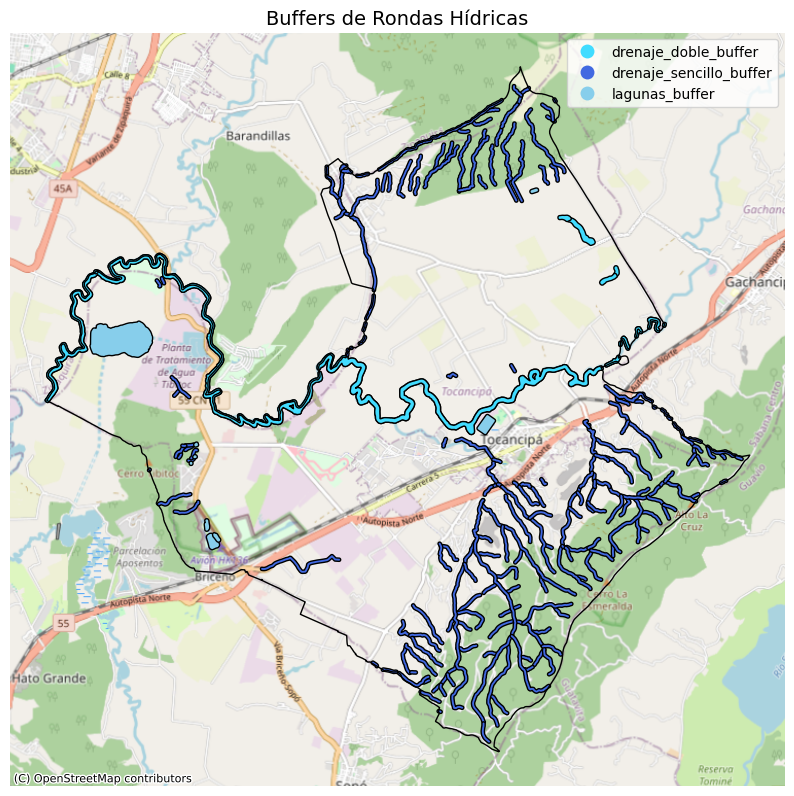

In [90]:
#Visualización áreas de influencia ronda hidrica

# Configurar figura
fig, ax = plt.subplots(figsize=(10, 10))

# Definir colores personalizados en el orden de las categorías
colores = ['#41dcff', '#4169E1', '#87CEEB'] 

# Crear el cmap
cmap = ListedColormap(colores)

# Plot de buffers de rondas hídricas
buffers_rondaH.plot(
    cmap=cmap,
    column="origen",
    categorical=True,
    legend=True,
    ax=ax,
    edgecolor='k'
)

# Plot de límite
municipio.plot(ax=ax, color='none', edgecolor='black', linewidth=1)

# Agregar mapa base
ctx.add_basemap(
    ax,
    source=ctx.providers.OpenStreetMap.Mapnik,
    crs=municipio.crs.to_string(),  # Asegura usar el CRS correcto
  )

# Configurar título y leyenda
ax.set_title("Buffers de Rondas Hídricas", fontsize=14)
ax.set_axis_off()
plt.show()

# Guardar el mapa generado 
fig.savefig(
    os.path.join(output_folder_maps, "Buffer_ronda_hidrica.png"),
    dpi=300,
    bbox_inches='tight'
)

## 1.5 GENERACIÓN DE TEMPORALES

Se generan archivos temporales de los resultados generados en el notebook de preparación, los cuales incluyen zonas no aptas (centros poblados existentes, bosques, zonificacion amenazas alta, suelos de protección, rondas hídricas) y criterios necesarios para identificar zonas de expansión urbana como la cobertura agricola de pastos y clasificacion de pendientes. Estos temporales permiten contar con insumos filtrados y consistentes para los análisis posteriores, garantizando eficiencia y trazabilidad en el flujo de trabajo, ya que serán utilizados directamente en el notebook de analisis.

In [91]:
#Zonas no aptas
centros_pob_clip.to_feather("centrospob.feather")
Bosques.to_feather("bosques_temporal.feather")
Amenaza_alta.to_feather("amenaza_temporal.feather")
Suelo_Proteccion.to_feather("sueloprot_temporal.feather")
buffers_rondaH.to_feather("buffers_ronda_temporal.feather")

#Criterios de selección zonas de expansión
municipio.to_feather("municipio.feather")
Pastos.to_feather("pastos_temporal.feather")
clas_pend.to_feather("clas_pend.feather")